We will walk through:
* The discovery, preparation and control of data
* Some descriptive analytics of the energy consumptions
* **Developping a model to forecast one day head (+1 day)**

[RUN] : tag defining a block of already written code you will have to run

[Q] : taf defining a question you will have to answer, with some code or text


# Discovery, preparation and control of data

[RUN]

In [ ]:
# Set up the environment, load a common packages to have them at hand
# get libraries
# -data = Pandas and Numpy
import numpy as np
import pandas as pd
# -viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# -ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


## Importing data
[RUN] We have done the import work for you. But feel free to import any other library if needed !

This first step aims at importing the dataset with only few of its original fields and type variables appropriately

In [ ]:
# Data source
DATA_SOURCE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
# Import data
consumptions = pd.read_csv(
    # Define the source
    DATA_SOURCE_URL,
    # Set separator
    sep =';',
    # Column names location
    header=0,
    # NA flag
    na_values='?',
    # Retain only a few columns
    usecols = ['Date','Time', 'Global_active_power'],
    # Type definition
    dtype={
        'Date':str,
        'Time':str,
        'Global_active_power':np.float64
    },
    # Date inference is not required
    infer_datetime_format=False
)

# Standardise column names using lower case
consumptions.rename(
    columns = {
        'Date':'date',
        'Time':'time',
        'Global_active_power':'total_consumption'
        },
    inplace=True
)
# Define the dataframe index based on the timestamp (date-time)
consumptions.index = pd.to_datetime(
    consumptions.date + "-" + consumptions.time,
    format = "%d/%m/%Y-%H:%M:%S"
)
# Drop the date and time variables that are now redondant with the index
consumptions.drop(columns=['date', 'time'], inplace=True)
# Color mapping for graphs
serie = ("total_consumption", "grey")

# We resample for you to continue the exercise
consumptions = consumptions.resample('D').sum()

## Discovery and preparation

### Can you perform some data checks and analytics?
[Q] Given we have at hand electricity consumptions:
- what should we check for data quality (e.g. missing value, typing of variables,...)?
- what should be the key analytics (e.g. main dynamics, temporal correlation,...) ?

In [ ]:
#discovery
consumptions.head()

,total_consumption
2006-12-16,1209.176
2006-12-17,3390.460
2006-12-18,2203.826
2006-12-19,1666.194
2006-12-20,2225.748


In [ ]:
consumptions.tail()

,total_consumption
2010-11-22,2041.536
2010-11-23,1577.536
2010-11-24,1796.248
2010-11-25,1431.164
2010-11-26,1488.104


In [ ]:
len(consumptions)

1442

### Data quality checks

In [ ]:
# Check for missing values
print("Missing Values:")
missing_values = consumptions.isnull().sum()
print(missing_values)

# Check variable typing
print("\nVariable Types:")
variable_types = consumptions.dtypes
print(variable_types)

# Summary statistics for 'total_consumption'
print("\nSummary Statistics:")
print(consumptions.describe().to_string())


Missing Values:
total_consumption    0
dtype: int64

Variable Types:
total_consumption    float64
dtype: object

Summary Statistics:
       total_consumption
count        1442.000000
mean         1551.334856
std           617.297117
min             0.000000
25%          1161.198500
50%          1534.778000
75%          1889.859500
max          4773.386000


# Key Analytics


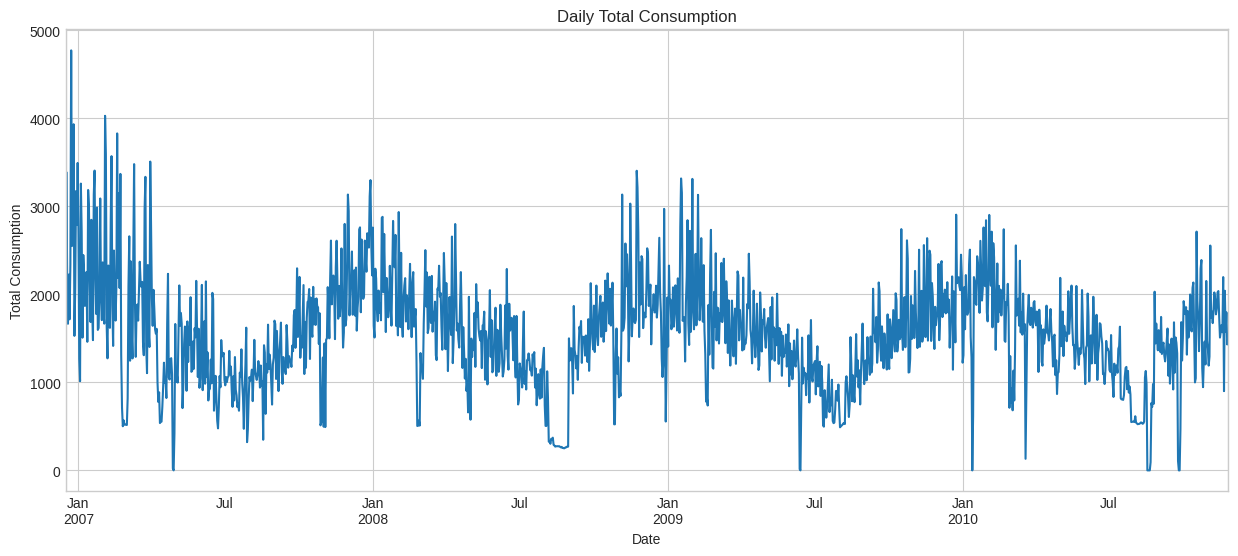

In [ ]:
# Temporal dynamics =>  Plotting the time series
consumptions['total_consumption'].plot(figsize=(15, 6), title='Daily Total Consumption')
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.show()

    Each year seems to show a similar pattern of rising and falling consumption, which reinforces the presence of seasonal effects.

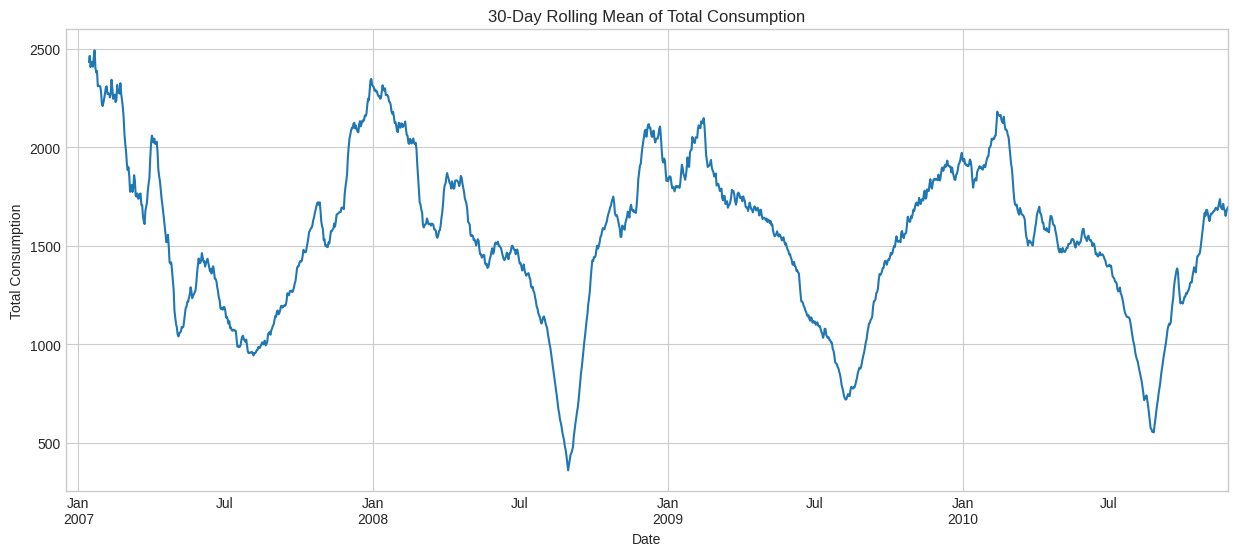

In [ ]:
# Rolling average for trend analysis
consumptions['total_consumption'].rolling(window=30).mean().plot(figsize=(15, 6), title='30-Day Rolling Mean of Total Consumption')
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.show()

    There appear to be regular fluctuations in the data that suggest seasonal patterns (peak in winter and drop in summer)
    Actually, the 30-day rolling mean helped identify longer-term trends in consumption data. => I detected seasonal changes

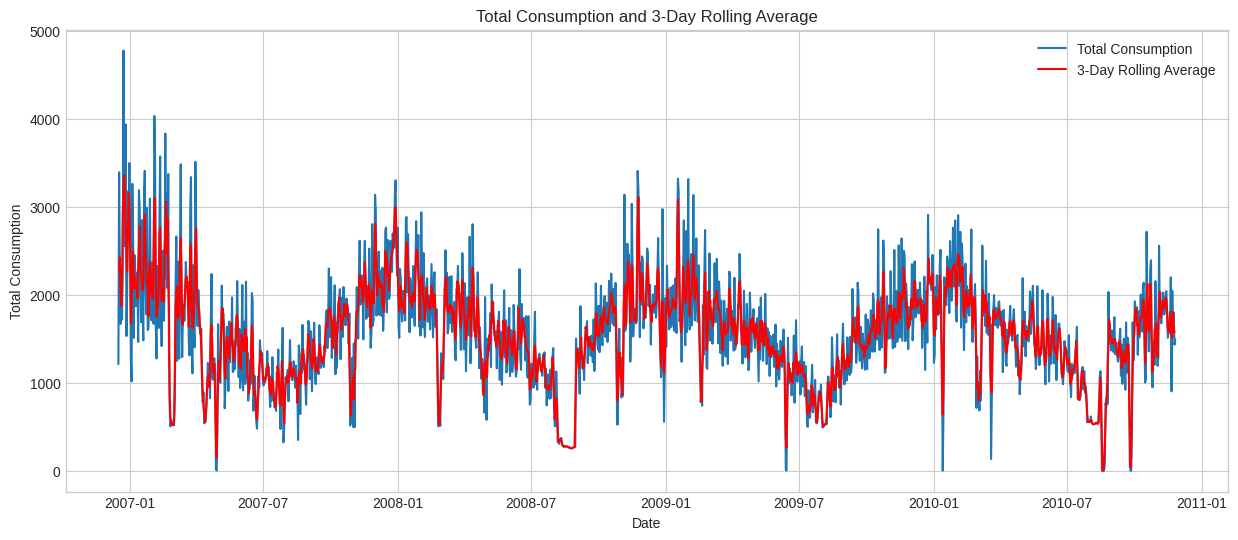

In [ ]:
# Calculate the 3-day rolling average
rolling_avg_3_days = consumptions['total_consumption'].rolling(window=3, center=True).mean()

# Plot both the original total consumption and the 3-day rolling average on the same plot
plt.figure(figsize=(15, 6))
plt.plot(consumptions.index, consumptions['total_consumption'], label='Total Consumption')
plt.plot(consumptions.index, rolling_avg_3_days, label='3-Day Rolling Average', color='red')
plt.title('Total Consumption and 3-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.legend()
plt.show()


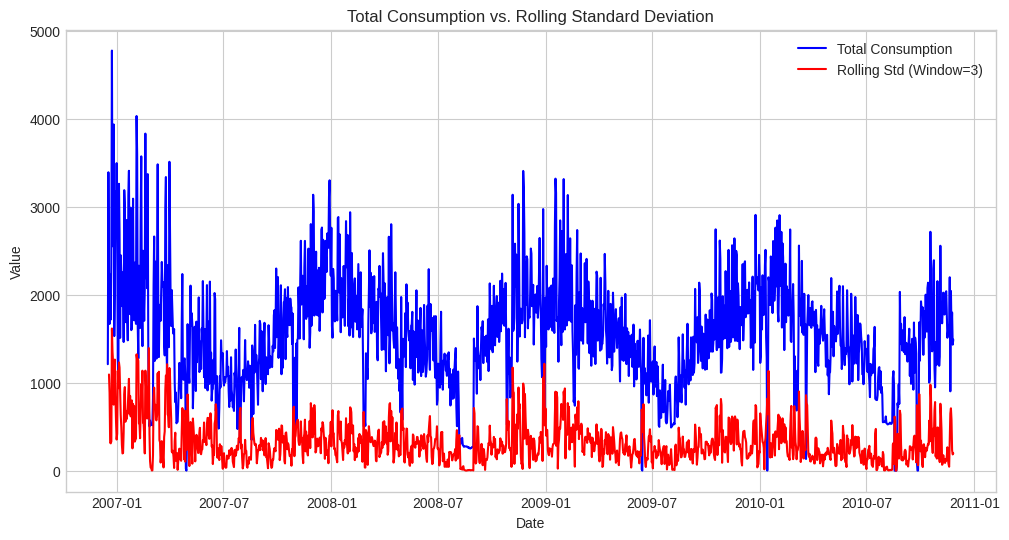

In [ ]:
# Calculate the rolling standard deviation
rolling_std_3 = consumptions['total_consumption'].rolling(window=3).std()

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the original time series
ax.plot(consumptions.index, consumptions['total_consumption'], label='Total Consumption', color='blue')

# Plot the rolling standard deviation
ax.plot(consumptions.index, rolling_std_3, label='Rolling Std (Window=3)', color='red')

# Add titles and labels
ax.set_title('Total Consumption vs. Rolling Standard Deviation')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()

# Show the plot
plt.show()


    When the rolling std goes up, it means that the daily consumption is varying more from one day to the next within that 3-day window.
    
    When the rolling std is low, it indicates that the daily consumption is more stable and consistent.
    
    It also seems to peak mostly in the same periods when consumption is high, suggesting that the variability in consumption is greater on days with higher overall consumption.

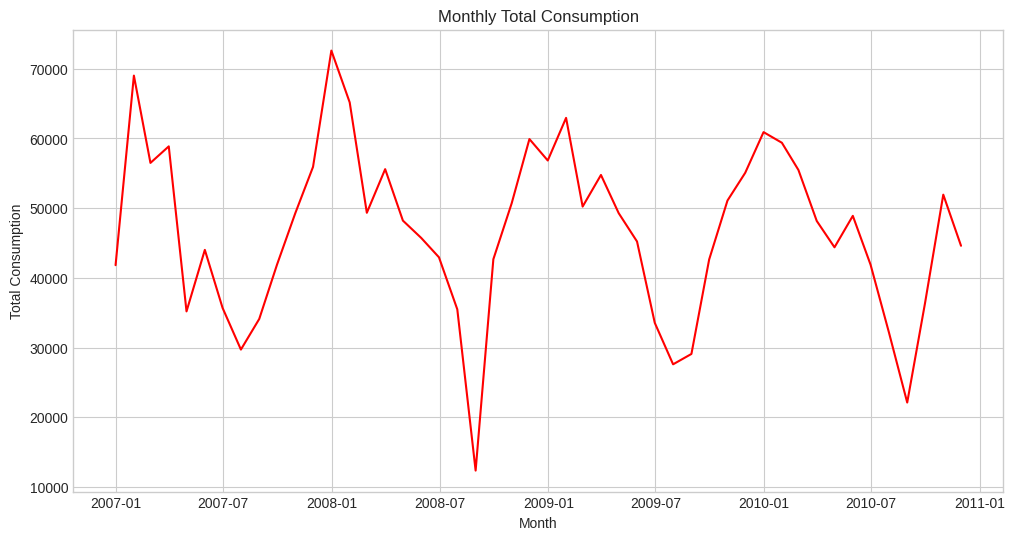

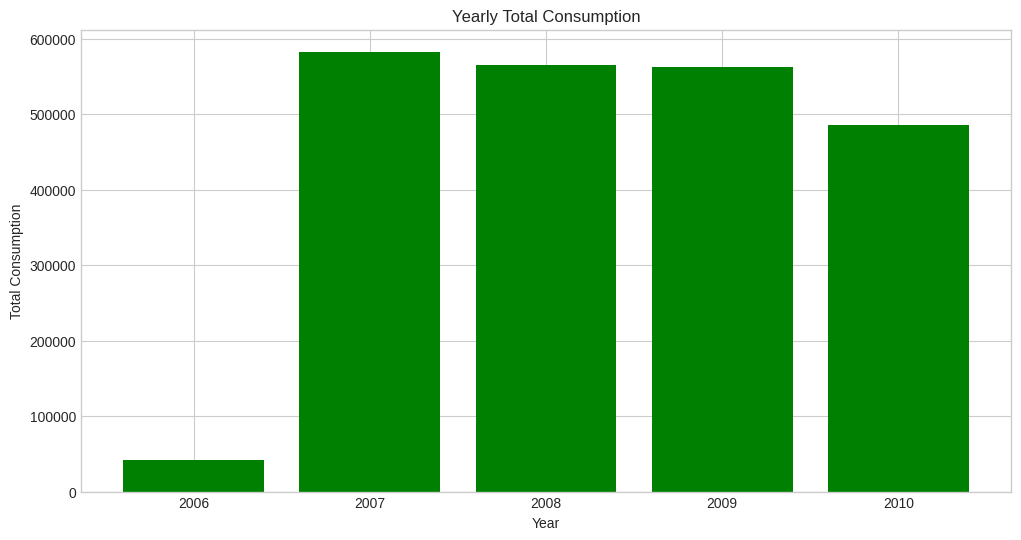

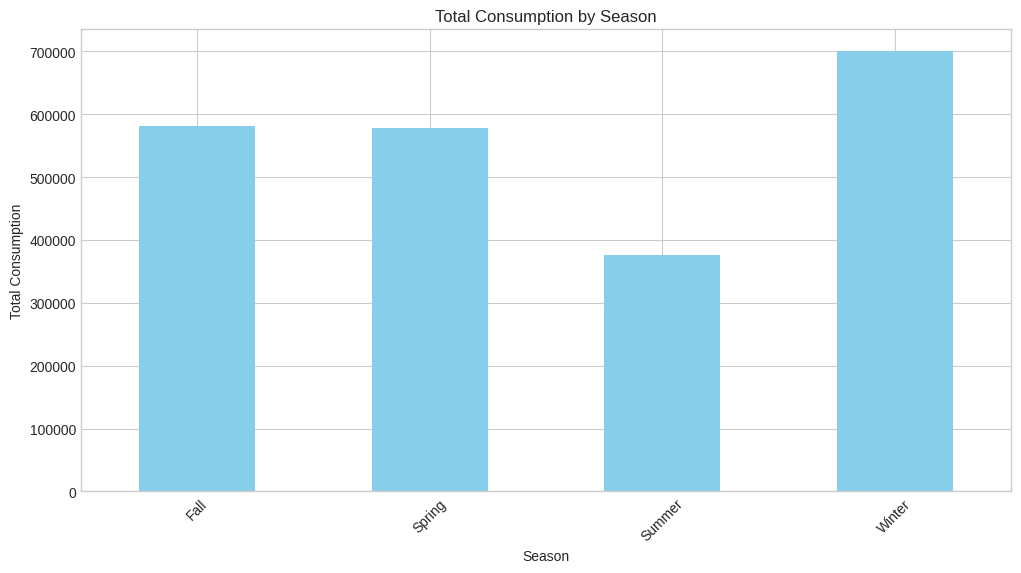

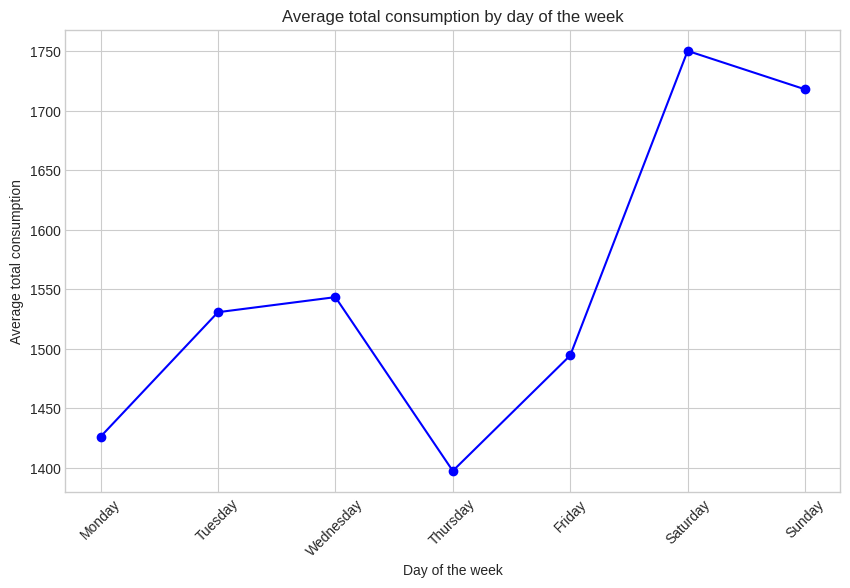

In [ ]:
# Main Dynamics Analysis

# Calculate monthly total consumption
monthly_consumption = consumptions.resample('M').sum()
# Plot monthly total consumption
plt.figure(figsize=(12, 6))
plt.plot(monthly_consumption.index, monthly_consumption['total_consumption'], color='red')
plt.title('Monthly Total Consumption')
plt.xlabel('Month')
plt.ylabel('Total Consumption')
plt.grid(True)
plt.show()

# Calculate yearly total consumption
yearly_consumption = consumptions.resample('Y').sum()
# Extract years from the index
years = yearly_consumption.index.year
# Plot yearly total consumption
plt.figure(figsize=(12, 6))
plt.bar(years, yearly_consumption['total_consumption'], color='green')
plt.title('Yearly Total Consumption')
plt.xlabel('Year')
plt.ylabel('Total Consumption')
plt.grid(True)
plt.show()

# Calculate seasonal total consumption
seasonal_consumption = consumptions.groupby(consumptions.index.month).sum()
# Map month numbers to season names
season_names = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Fall',
    12: 'Winter'
}
# Add a new column 'Season' based on the mapped season names
seasonal_consumption['Season'] = seasonal_consumption.index.map(season_names)
# Group by season and calculate the total consumption for each season
seasonal_consumption_grouped = seasonal_consumption.groupby('Season')['total_consumption'].sum()
# Plot seasonal total consumption as histograms
plt.figure(figsize=(12, 6))
seasonal_consumption_grouped.plot(kind='bar', color='skyblue')
plt.title('Total Consumption by Season')
plt.xlabel('Season')
plt.ylabel('Total Consumption')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Group the data by the day of the week and calculate the mean of the total consumption
daily_avg_consumption = consumptions.groupby(consumptions.index.dayofweek)['total_consumption'].mean()
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg_consumption.index = days_of_week
# Plot
plt.figure(figsize=(10, 6))
plt.plot(daily_avg_consumption.index, daily_avg_consumption.values, marker='o', color='blue')
plt.title('Average total consumption by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Average total consumption')
plt.xticks(rotation=45)  # For better readability of the day labels
plt.grid(True)
plt.show()


In [ ]:
#calculate correlation between current day and previous day
correlation_between_current_and_previous_Day = consumptions['total_consumption'].corr(consumptions['total_consumption'].shift(1))
print("\nTemporal Correlation between Current and Previous Day's Consumption:", correlation_between_current_and_previous_Day)

#calculate correlation between weekends
# Aggregate consumption for each weekend (Saturday + Sunday)
weekend_consumption = consumptions.resample('W-SAT').sum()
# Shift the aggregated consumption series by one week to get the consumption of the previous weekend
previous_weekend_consumption = weekend_consumption['total_consumption'].shift(1)
# Calculate the correlation between current weekend consumption and previous weekend consumption
correlation_weekends = weekend_consumption['total_consumption'].corr(previous_weekend_consumption)


# Resample data to monthly frequency and calculate correlation between consecutive months
monthly_consumption = consumptions.resample('M').sum()
correlation_monthly = monthly_consumption['total_consumption'].corr(monthly_consumption['total_consumption'].shift(1))
print("Correlation between monthly consumption and previous month's consumption:", correlation_monthly)

# Resample data to seasonal frequency (e.g., 'Q' for quarterly) and calculate correlation between consecutive seasons
seasonal_consumption = consumptions.resample('Q').sum()
correlation_seasonal = seasonal_consumption['total_consumption'].corr(seasonal_consumption['total_consumption'].shift(1))
print("Correlation between seasonal consumption and previous season's consumption:", correlation_seasonal)

# Resample data to annual frequency and calculate correlation between consecutive years
annual_consumption = consumptions.resample('Y').sum()
correlation_annual = annual_consumption['total_consumption'].corr(annual_consumption['total_consumption'].shift(1))
print("Correlation between annual consumption and previous year's consumption:", correlation_annual)




Temporal Correlation between Current and Previous Day's Consumption: 0.6175786909396925
Correlation between monthly consumption and previous month's consumption: 0.5894627208507874
Correlation between seasonal consumption and previous season's consumption: -0.17523425716961782
Correlation between annual consumption and previous year's consumption: -0.5035931869832339


### Your dynamic view and conclusions




[Q] Below your have some code for a hourly view that, with the high frequence, prevent an easy reading.

**Please modify it your way to have a more helpful view.**

In [ ]:
def plot_serie_temp(df, serie):
    # Create figure with all series
    fig = go.Figure()
    # Add all consumptions
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df[serie[0]],
        name =serie[0],
        line_color=serie[1]
    ))
    # Layout with range selector
    fig.update_layout(
        title=go.layout.Title( text="Consumption over years"),
        # Define axes
         xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(text="Date (select the period)"),
            rangeselector=dict(
                buttons=list([
                    dict(count=6, label="Last 6 month", step="month", stepmode="backward"),
                    dict(count=1, label="Last year", step="year", stepmode="backward"),
                    dict(label="Full dataset", step="all")
                ])
            )
        ),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Consumption (kW.h)")),
        xaxis_rangeslider_visible=True)
    # render plot
    fig.show()

# Apply plot function
plot_serie_temp(consumptions.resample('H').sum(), serie)

In [ ]:
#Modified code
import plotly.graph_objects as go

def plot_consumption_over_months(df):
    # Aggregate data to monthly frequency
    monthly_data = df.resample('M').sum()

    # Create figure with consumption series
    fig = go.Figure()

    # Add consumption data as a line plot with markers
    fig.add_trace(go.Scatter(
        x=monthly_data.index,
        y=monthly_data['total_consumption'],
        mode='lines+markers',
        name='Consumption (kW.h)',
        line=dict(color='RoyalBlue', width=3),
        marker=dict(color='LightSkyBlue', size=8),
        hoverinfo='x+y'
    ))

    # Layout settings
    fig.update_layout(
        title='Electricity Consumption Over Months',
        xaxis_title='Month',
        yaxis_title='Consumption (kW.h)',
        xaxis=dict(
            tickmode='array',
            tickvals=monthly_data.index,
            ticktext=monthly_data.index.strftime('%B %Y'),
            tickangle=-45,
            rangeslider_visible=True,
            rangeselector=dict(
                buttons=list([
                    dict(count=6, label="Last 6 Months", step="month", stepmode="backward"),
                    dict(count=1, label="Last Year", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            )
        ),
        yaxis=dict(
            fixedrange=False
        ),
        template='plotly_white',
        hovermode='x unified'
    )

    # Make layout responsive
    fig.update_layout(autosize=True)

    # Show plot
    fig.show()

# Plot the consumption data over months
plot_consumption_over_months(consumptions)


##### [Q] Your conclusions on the dynamic of the time serie

    The analysis of yearly total consumption doesn't yield significant insights, suggesting a stable consumption pattern over the years.

    Seasonal analysis reveals a notable decrease in consumption during summer months (July and August) and an increase during winter months, peaking in January. This seasonal variation indicates a consistent pattern of lower demand in warmer months and higher demand in colder months.

    Weekend consumption shows an increase compared to regular weekdays, suggesting different consumption behaviors during weekends, possibly due to leisure activities or increased appliance usage.

    The moderately strong positive correlation (correlation coefficient ≈ 0.625) between weekend consumption and previous weekend's consumption indicates a consistent trend in weekend consumption over consecutive weekends.

    The moderately strong positive correlation (correlation coefficient ≈ 0.618) between daily consumption and the consumption of the previous day suggests persistent patterns or trends in daily consumption.

    Monthly consumption exhibits a moderately strong positive correlation (correlation coefficient ≈ 0.589) with the consumption of the previous month, indicating consistent patterns or trends in monthly consumption over consecutive months.

    The weak negative correlation (correlation coefficient ≈ -0.175) between seasonal consumption and previous season's consumption suggests some variability or changes in consumption patterns between consecutive seasons.

    The moderate negative correlation (correlation coefficient ≈ -0.504) between annual consumption and the consumption of the previous year suggests some variability or changes in consumption patterns between consecutive years.

    ==> The electricity consumption data demonstrates distinct seasonal trends, with lower demand in summer and higher demand in winter. Additionally, variations are observed between weekdays and weekends, with increased consumption during weekends.






## Features and Model selection

[RUN] We want to predict the consumption one day in advance.
We suggest the following features (including the target, the variable of interest):

In [ ]:
# Creation of the target ("tomorrow" value)
consumptions["target"] = consumptions["total_consumption"].shift(-1)
# Creation of the a yesterday value variable
consumptions["consumption_lag1"] = consumptions["total_consumption"].shift(1)
# Creation of a calendar feature
consumptions["consumption_month"] = consumptions.index.month
# Creation of the month value of the target
consumptions["target_month"] = consumptions.index.shift(-1).month


[Q] **Feel free to add other interesting variables, based on your previous

---

observations of the signal and understanding of the use case.**

In [ ]:
# Create a dictionary to map months to seasons
seasons = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10:4,
    11: 4,
    12: 1
}

# Map the month of the target to its corresponding season
consumptions['target_season'] = consumptions.index.shift(-1).month.map(seasons)

# Create binary columns indicating the target season
consumptions['target_winter'] = (consumptions['target_season'] == 1).astype(int) #if target is in winter=> target_winter=1 else 0

# Drop the original target_season column
consumptions.drop(columns=['target_season'], inplace=True)

# Add day of the week as a feature
consumptions['day_of_week'] = consumptions.index.dayofweek

# Add week of the year as a feature
consumptions['week_of_year'] = consumptions.index.isocalendar().week

# More lagged features
consumptions['consumption_lag2'] = consumptions['total_consumption'].shift(2)
consumptions['consumption_lag3'] = consumptions['total_consumption'].shift(3)

# Rolling window statistics
consumptions['rolling_mean_3'] = consumptions['total_consumption'].rolling(window=3).mean()# enables us to smooth out noise and highlight underlying trends, providing valuable insights into long-term patterns and potential shifts.
#consumptions['rolling_mean_3'] = consumptions['total_consumption'].rolling(window=3,center='True').mean()

# Create a binary column indicating whether the target day is a weekend
consumptions['is_target_weekend'] = consumptions.index.shift(-1).weekday.isin([5, 6]).astype(int)

# Ensure there are no NaN values created by shifting
consumptions.dropna(inplace=True)

    • Day of the Week: As a categorical feature to capture the weekly pattern.

    • Week of the Year: To capture the annual consumption pattern.

    • Lagged Features for Recent Days: Including more lagged days (lag2, lag3) improved the model by capturing short-term fluctuations
    

In [ ]:
consumptions

,total_consumption,target,consumption_lag1,consumption_month,target_month,target_winter,day_of_week,week_of_year,consumption_lag2,consumption_lag3,rolling_mean_3,is_target_weekend
2006-12-19,1666.194,2225.748,2203.826,12,12,1,1,51,3390.460,1209.176,2420.160000,0
2006-12-20,2225.748,1716.624,1666.194,12,12,1,2,51,2203.826,3390.460,2031.922667,0
2006-12-21,1716.624,2341.338,2225.748,12,12,1,3,51,1666.194,2203.826,1869.522000,0
2006-12-22,2341.338,4773.386,1716.624,12,12,1,4,51,2225.748,1666.194,2094.570000,0
2006-12-23,4773.386,2550.012,2341.338,12,12,1,5,51,1716.624,2225.748,2943.782667,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-21,900.910,2041.536,2197.006,11,11,0,6,46,1570.400,1652.152,1556.105333,1
2010-11-22,2041.536,1577.536,900.910,11,11,0,0,47,2197.006,1570.400,1713.150667,1
2010-11-23,1577.536,1796.248,2041.536,11,11,0,1,47,900.910,2197.006,1506.660667,0
2010-11-24,1796.248,1431.164,1577.536,11,11,0,2,47,2041.536,900.910,1805.106667,0


### Model construction
 [RUN] We propose you to use a classic random forest for the inference.

In [ ]:
# Specify the number of trees
n_estimators = 300
regr = RandomForestRegressor(n_estimators=n_estimators, random_state=42,max_depth=10,max_features='sqrt')

In [ ]:
# Determine the cutoff date for splitting the data
cutoff_date = '2010-01-01'
# Filter the dataset based on the cutoff date
train_data = consumptions[consumptions.index < cutoff_date]
test_data = consumptions[consumptions.index >= cutoff_date]


## Evaluation



[texte du lien](https://)[Q] Train your model with your data and compute the performance with the metric of your choice.

In [ ]:
# Separate features and target,
X_train=train_data[[ 'consumption_lag1','consumption_month', 'target_month', 'target_winter', 'is_target_weekend','consumption_lag2','consumption_lag3','rolling_mean_3','day_of_week','week_of_year' ]]
X_test=test_data[[ 'consumption_lag1','consumption_month', 'target_month', 'target_winter', 'is_target_weekend','consumption_lag2','consumption_lag3','rolling_mean_3','day_of_week','week_of_year']]
y_train=train_data['target']
y_test=test_data['target']

# Instantiate and train the random forest model
regr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regr.predict(X_test)

# Calculate the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
#print("R-squared (R2):", r2)


Mean Absolute Error (MAE): 295.5154193409072


Plotting only the predicted values against dates

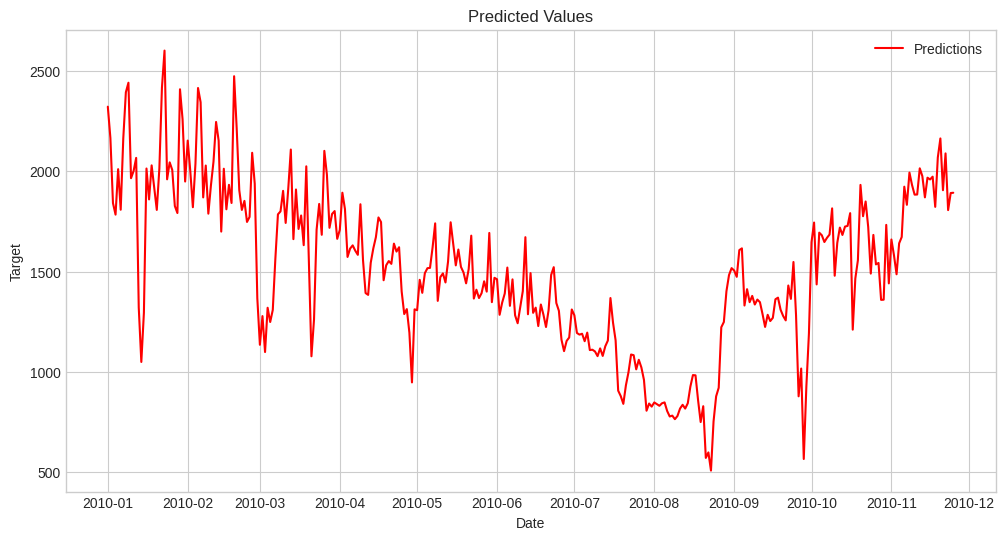

In [ ]:
# Plotting only the predicted values
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_pred, label='Predictions', color='red')
plt.title('Predicted Values')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()


\[Q] Compare graphically your predictions with the real consumptions.\::

<ipython-input-505-5ac47400590d>:3: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



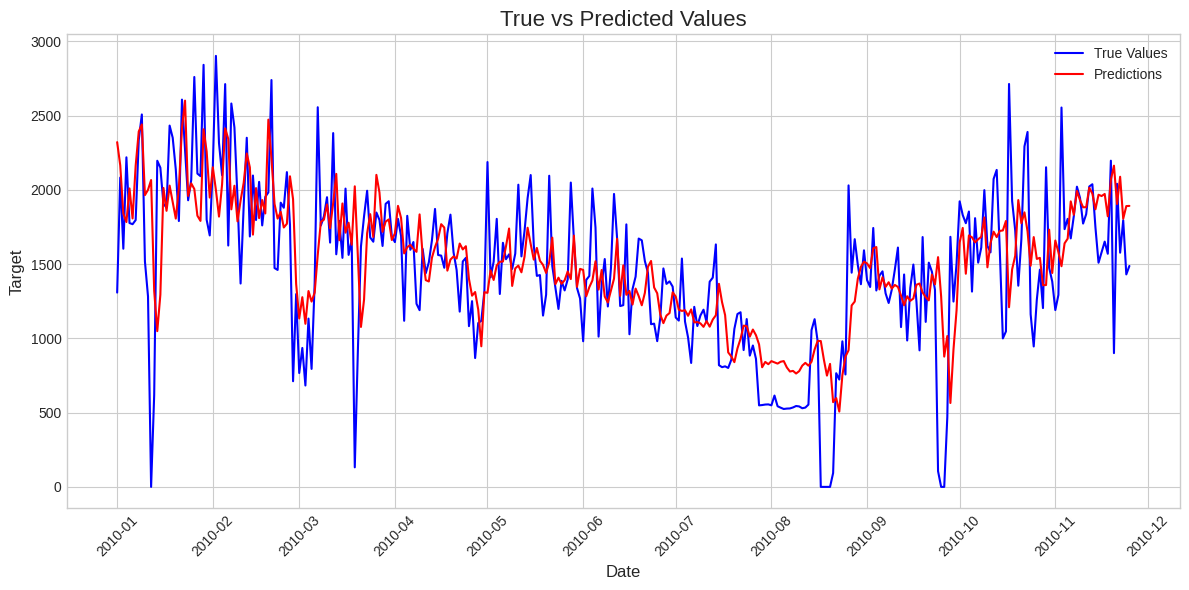

In [ ]:
# Set figure size and style
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-whitegrid')

# Plot true values and predicted values against dates
plt.plot(X_test.index, y_test, label='True Values', color='blue')
plt.plot(X_test.index, y_pred, label='Predictions', color='red')

# Add title and labels
plt.title('True vs Predicted Values', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Target', fontsize=12)

# Add legend and grid
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()



## Make it an app


[Q] We now want our users to be able to call our trained model to have consumption predictions for the next day.

We decide to construct an api for that purpose.

Behind this service we want to call a specific function that:
* retrieves consumption data,
* cleans, preprocess them,
* train a model with them,
* and predict the next day consumption as a return for the users.

**Please package properly and intelligently in a global function the previous coded blocks to do so and define also the function arguments with what seems the most appropriate for the users request.**

In [ ]:
def train_and_predict(data_source_url,day_features):
    # Check if day_features is a DataFrame , actually day_features are the features of the day for which we want to predict the next day's consumption
    if not isinstance(day_features, pd.DataFrame):
        raise ValueError("day_features must be a pandas DataFrame")

    # Check if day_features contains all required columns
    required_columns = ['consumption_lag1', 'consumption_month', 'target_month', 'target_winter', 'is_target_weekend',
                        'consumption_lag2', 'consumption_lag3', 'rolling_mean_3', 'day_of_week', 'week_of_year']
    missing_columns = set(required_columns) - set(day_features.columns)
    if missing_columns:
        raise ValueError(f"day_features is missing the following required columns: {missing_columns}")


    #Import data
    consumptions = pd.read_csv(
        data_source_url,
        sep=';',
        header=0,
        na_values='?',
        usecols=['Date', 'Time', 'Global_active_power'],
        dtype={'Date': str, 'Time': str, 'Global_active_power': np.float64},
        infer_datetime_format=False
    )

    # Preprocess data
    consumptions.rename(columns={'Date': 'date', 'Time': 'time', 'Global_active_power': 'total_consumption'}, inplace=True)
    consumptions.index = pd.to_datetime(consumptions.date + "-" + consumptions.time, format="%d/%m/%Y-%H:%M:%S")
    consumptions.drop(columns=['date', 'time'], inplace=True)
    consumptions = consumptions.resample('D').sum()
    consumptions['target'] = consumptions['total_consumption'].shift(-1)
    consumptions['consumption_lag1'] = consumptions['total_consumption'].shift(1)
    consumptions['consumption_month'] = consumptions.index.month
    consumptions['target_month'] = consumptions.index.shift(-1).month
    # Create a dictionary to map months to seasons
    seasons = {
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 2,
        6: 3,
        7: 3,
        8: 3,
        9: 4,
        10:4,
        11: 4,
        12: 1
    }

    # Map the month of the target to its corresponding season and create a new column
    consumptions['target_season'] = consumptions.index.shift(-1).month.map(seasons)

    # Create binary columns indicating the target season
    consumptions['target_winter'] = (consumptions['target_season'] == 1).astype(int) #if target is in winter=> target_winter=1 else 0

    # Drop the original target_season column
    consumptions.drop(columns=['target_season'], inplace=True)

    # Add day of the week as a feature
    consumptions['day_of_week'] = consumptions.index.dayofweek

    # Add week of the year as a feature
    consumptions['week_of_year'] = consumptions.index.isocalendar().week

    # More lagged features
    consumptions['consumption_lag2'] = consumptions['total_consumption'].shift(2)
    consumptions['consumption_lag3'] = consumptions['total_consumption'].shift(3)

    # Rolling window statistics
    consumptions['rolling_mean_3'] = consumptions['total_consumption'].rolling(window=3).mean()
    #consumptions['rolling_std_3'] = consumptions['total_consumption'].rolling(window=3,center=True).std()

    # Create a binary column indicating whether the target day is a weekend
    consumptions['is_target_weekend'] = consumptions.index.shift(-1).weekday.isin([5, 6]).astype(int)

    # Ensure there are no NaN values created by shifting
    consumptions.dropna(inplace=True)

    # Split the data into training and testing sets
    # Determine the cutoff date for splitting the data
    cutoff_date = '2010-01-01'

    # Filter the dataset based on the cutoff date
    train_data = consumptions[consumptions.index < cutoff_date]
    test_data = consumptions[consumptions.index >= cutoff_date]

    # Separate features and target,
    X_train=train_data[[ 'consumption_lag1','consumption_month', 'target_month', 'target_winter', 'is_target_weekend','consumption_lag2','consumption_lag3','rolling_mean_3','day_of_week','week_of_year' ]]
    X_test=test_data[[ 'consumption_lag1','consumption_month', 'target_month', 'target_winter', 'is_target_weekend','consumption_lag2','consumption_lag3','rolling_mean_3','day_of_week','week_of_year']]
    y_train=train_data['target']
    y_test=test_data['target']

    # Instantiate and train the random forest model
    regr = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=10,max_features='sqrt')
    regr.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = regr.predict(X_test)

    # Calculate the model performance
    mae = mean_absolute_error(y_test, y_pred)

    # Predict next day's consumption
    next_prediction = regr.predict(day_features)

    return next_prediction


In [ ]:
# Example usage:
DATA_SOURCE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
day_features = pd.DataFrame({'consumption_lag1': [1500], 'consumption_month': [2], 'target_month': [3], 'target_winter': [0], 'is_target_weekend': [0], 'consumption_lag2': [1400], 'consumption_lag3': [1300], 'rolling_mean_3': [1400], 'day_of_week': [1], 'week_of_year': [7]})

next_prediction=train_and_predict(DATA_SOURCE_URL,day_features)
print(next_prediction)

[1651.10430155]


# Congrats, you are all done! Take a breath.